In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
#warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Input, multiply, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

1. Перекрытие 50 на 50
2. Делим выборку на 2 и сверяем их
3. Размечаем одинаковые-разные
4. Пока фиксированная ширина окна
5. Модель принимает вектор пока что, но какие варианты? 2 канала, скрытое состояние либо автокодировщик

1. Функция, которая генерирует сигналы с заданным перекрытием
2. Функция которая раскидывает по спектрам с окном

Еще мысль - читаем спектр с маленьким окном и потом подаем в рекуррентную сетку как эмбеддинги

In [10]:
def concatenate_signals(window , mean1, mean2, overlap ):
    """
    Функция принимает размер будущего сигнала, параметры усреднения стыка сигналов, перекрытие, и частоту дискретизации
    :param window:
    :param mean1:
    :param mean2:
    :param overlap:
    :param SAMPLE_RATE:
    :return: signal + label
    """
    duration = window * 2  # Секунды
    if overlap == 0:
        x1 = np.random.normal(0,1,duration)
        x1 = pd.Series(x1).rolling(window = mean1).mean().dropna()
        x1 = x1/(np.abs(x1).max())
        return x1[:window], 0
    else:
        x1 = np.random.normal(0,1,duration) # Первый сигнал
        x2 = np.random.normal(0,1,duration) # Второй сигнал

        # Усреднение, обрезание, нормировка, склейка
        x1 = pd.Series(x1).rolling(window = mean1).mean().dropna().values
        x2 = pd.Series(x2).rolling(window = mean2).mean().dropna().values
        x1 = x1/(np.abs(x1).max())
        x2 = x2/(np.abs(x2).max())
        len_1 = int(window * (1 - overlap))
        len_2 = window - len_1
        x1 = x1
        x2 = x2
        x = np.concatenate((x1[:len_1],x2[:len_2]))
        return x, 1

In [11]:
def make_signals(WINDOW, N_signals, overlap):
    mean1 = random.randint(2,6)
    mean2 = random.randint(2,6)
    while mean1 == mean2:
        mean2 = random.randint(2,5)
    signals = []
    y = []

    for i in range(int(N_signals/2)):
        signal, label = concatenate_signals(window = WINDOW, mean1 = mean1, mean2 = mean2, overlap = overlap)
        signals.append(signal)
        y.append(label)
        signal, label = concatenate_signals(window = WINDOW, mean1 = mean1, mean2 = mean2, overlap = 0)
        signals.append(signal)
        y.append(label)

    signals = [np.array(i) for i in signals]

    return signals, y

In [5]:
def make_spectr(signals,second_part = 0.5):
    ind = int(len(signals[0]) * (1 - second_part))
    signal_1 = [i[:ind] for i in signals]
    signal_2 = [i[ind:] for i in signals]
    signal_1_fft = [np.abs(rfft(i.flatten())) for i in signal_1]
    signal_1_fft = [i/i.max() for i in signal_1_fft]
    signal_2_fft = [np.abs(rfft(i.flatten())) for i in signal_2]
    signal_2_fft = [i/i.max() for i in signal_2_fft]
    signal_1_fft = np.array(signal_1_fft)
    signal_2_fft = np.array(signal_2_fft)
    print('Размеры спектров', signal_1_fft.shape, signal_2_fft.shape)
    return signal_1_fft, signal_2_fft

In [12]:
def make_spectr2(signals):
    signals_fft = [np.abs(rfft(i.flatten())) for i in signals]
    signals_fft = [i/i.max() for i in signals_fft]
    signals_fft = np.array(signals_fft)
    print('Размер спектров', signals_fft .shape)
    return signals_fft

In [6]:
def compile_and_learn(model, X_train, y_train, X_test, y_test,  epochs, optimizer, loss, metrics, batch_size):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    model.summary()

    # Обучение модели
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        verbose = 1)

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict(X_train), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model

In [7]:
def prepare_data_1(signal_1_fft, signal_2_fft, y):
    X = np.concatenate([signal_1_fft, signal_2_fft], axis=1)
    y = to_categorical(y)
    print('signal_1_fft', signal_1_fft.shape)
    print('signal_2_fft', signal_2_fft.shape)
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3)
    print('X_train', X_train.shape)
    print('y_train', y_train.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)
    return X_train, X_test, y_train, y_test

In [13]:
def prepare_data_2(signals_fft, y):
    X = signals_fft
    y = to_categorical(y)
    print('signals_fft', signals_fft.shape)
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3)
    print('X_train', X_train.shape)
    print('y_train', y_train.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)
    return X_train, X_test, y_train, y_test

# Сначала весь спектр целиком

In [27]:
signals, y = make_signals(WINDOW = 300, N_signals = 5000, overlap = 0.2)
signals_fft = make_spectr2(signals)
X_train, X_test, y_train, y_test = prepare_data_2(signals_fft, y)

Размер спектров (5000, 151)
signals_fft (5000, 151)
X_train (3500, 151)
y_train (3500, 2)
X_test (1500, 151)
y_test (1500, 2)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 151)]             0         
                                                                 
 dense_12 (Dense)            (None, 32)                4864      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 66        
                                                                 
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
219/219 [==============================] - 1s 3ms/step - loss: 0.7089 - accuracy: 0.5209 - val_loss: 0.6742 - val_accuracy: 0.5847
Epoch 2/50
219/219 [===========================

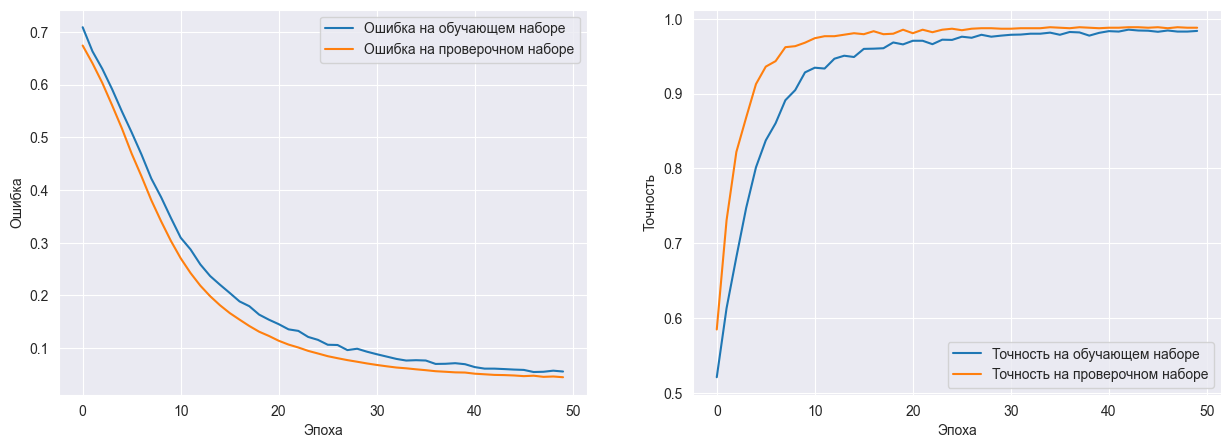

In [28]:
input1 = Input(X_train.shape[1])
l = Dense(32, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 50, optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.5, спектр 0.5

In [98]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.5)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.5)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 751) (5000, 751)
signal_1_fft (5000, 751)
signal_2_fft (5000, 751)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_24 (Dense)            (None, 64)                96192     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0329 - accuracy: 0.9914 - val_loss: 6.8087e-04 - val_accuracy: 1.0000
Epoch 2/20
219/219 [====================

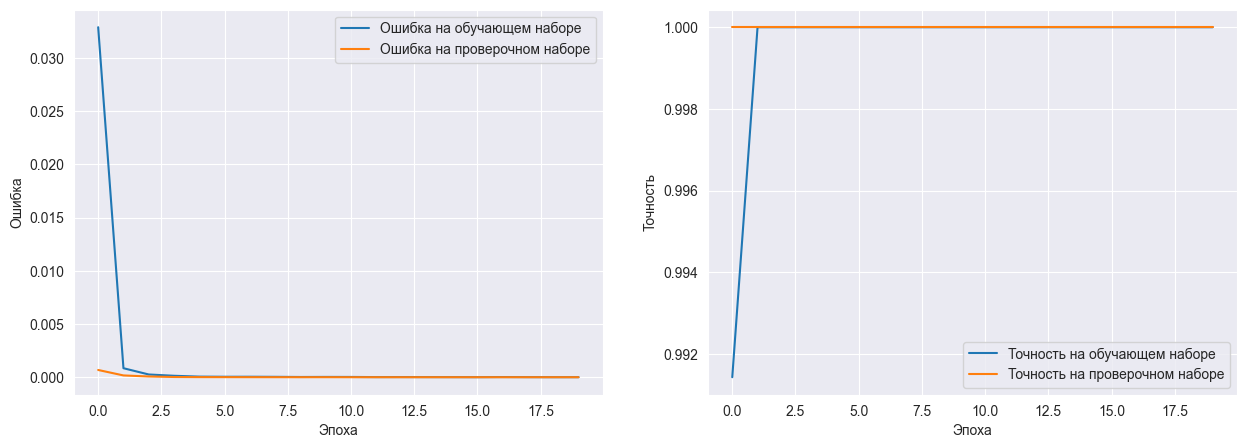

In [99]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 20, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.4, спектр 0.5

In [100]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.4)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.5)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 751) (5000, 751)
signal_1_fft (5000, 751)
signal_2_fft (5000, 751)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_26 (Dense)            (None, 64)                96192     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1214 - accuracy: 0.9654 - val_loss: 0.0090 - val_accuracy: 0.9993
Epoch 2/20
219/219 [========================

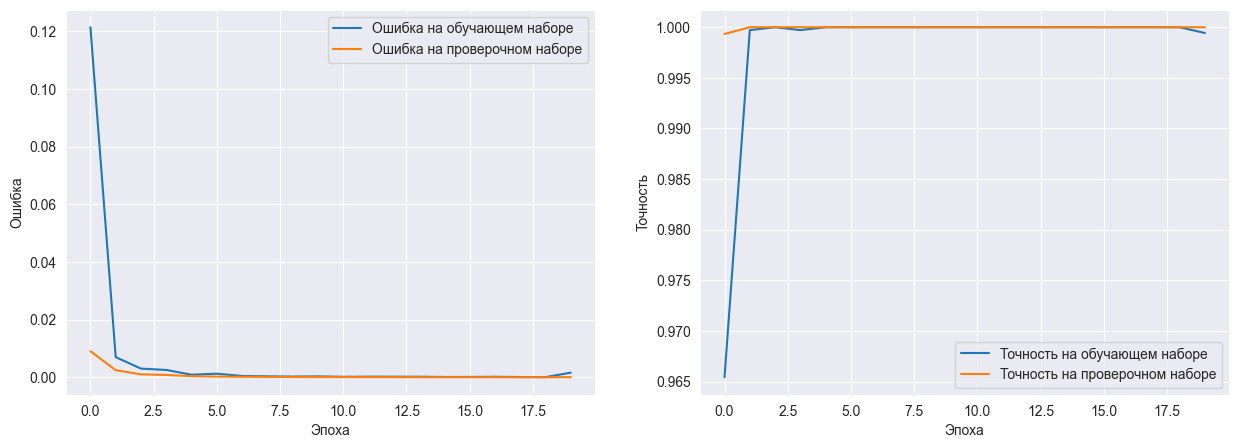

In [101]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 20, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.3, спектр 0.5

In [102]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.3)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.5)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 751) (5000, 751)
signal_1_fft (5000, 751)
signal_2_fft (5000, 751)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_28 (Dense)            (None, 64)                96192     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1479 - accuracy: 0.9609 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 2/20
219/219 [========================

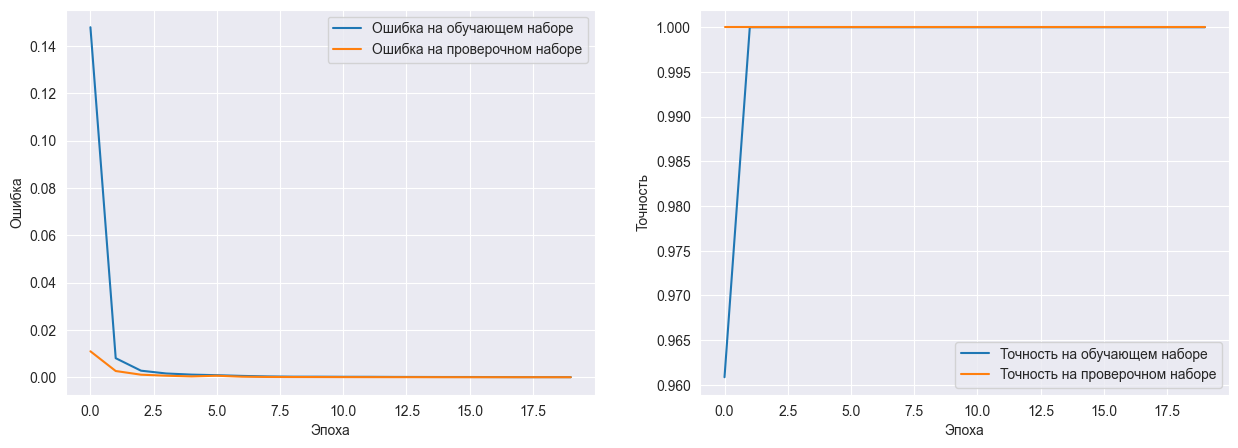

In [103]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 20, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.2, спектр 0.5

In [105]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.5)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 751) (5000, 751)
signal_1_fft (5000, 751)
signal_2_fft (5000, 751)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_30 (Dense)            (None, 64)                96192     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1432 - accuracy: 0.9546 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 2/20
219/219 [========================

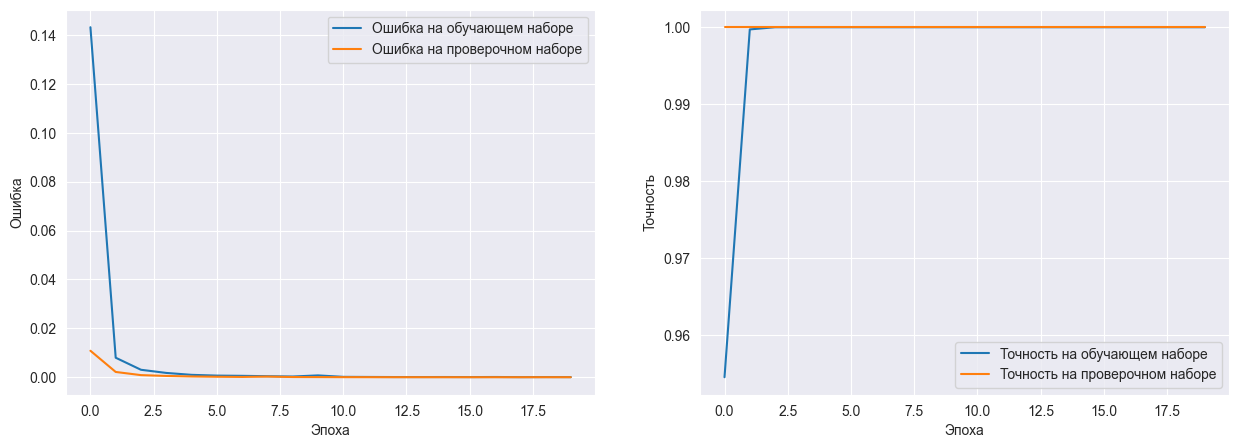

In [106]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 20, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.1, спектр 0.5

In [110]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.1)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.5)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 751) (5000, 751)
signal_1_fft (5000, 751)
signal_2_fft (5000, 751)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_34 (Dense)            (None, 128)               192384    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 2)                 258       
                                                                 
Total params: 192,642
Trainable params: 192,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 2s 8ms/step - loss: 0.3671 - accuracy: 0.8666 - val_loss: 0.0744 - val_accuracy: 1.0000
Epoch 2/25
219/219 [======================

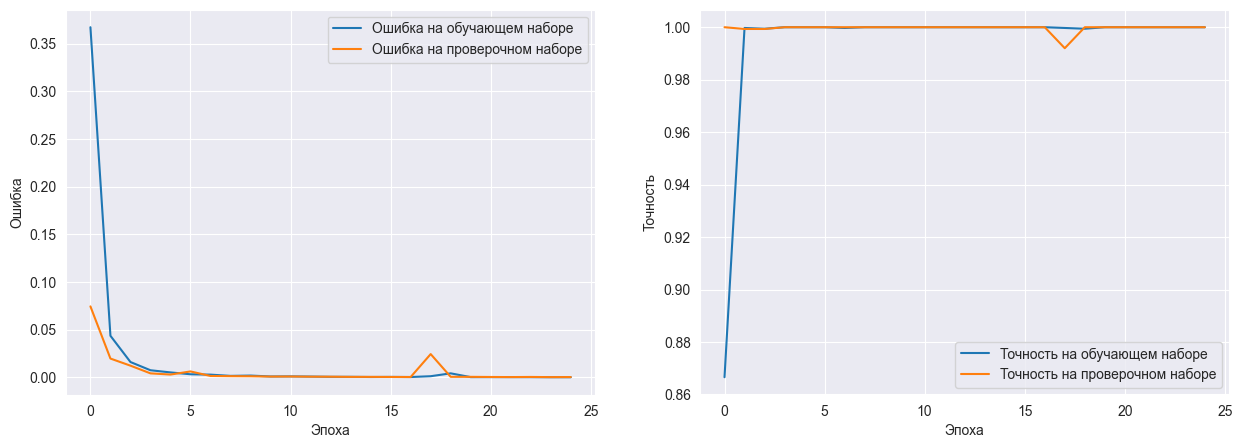

In [111]:
input1 = Input(X_train.shape[1])
l = Dense(128, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.4, спектр 0.2

In [113]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.4)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 1201) (5000, 301)
signal_1_fft (5000, 1201)
signal_2_fft (5000, 301)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_36 (Dense)            (None, 64)                96192     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 2s 8ms/step - loss: 0.1362 - accuracy: 0.9623 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 2/25
219/219 [========================

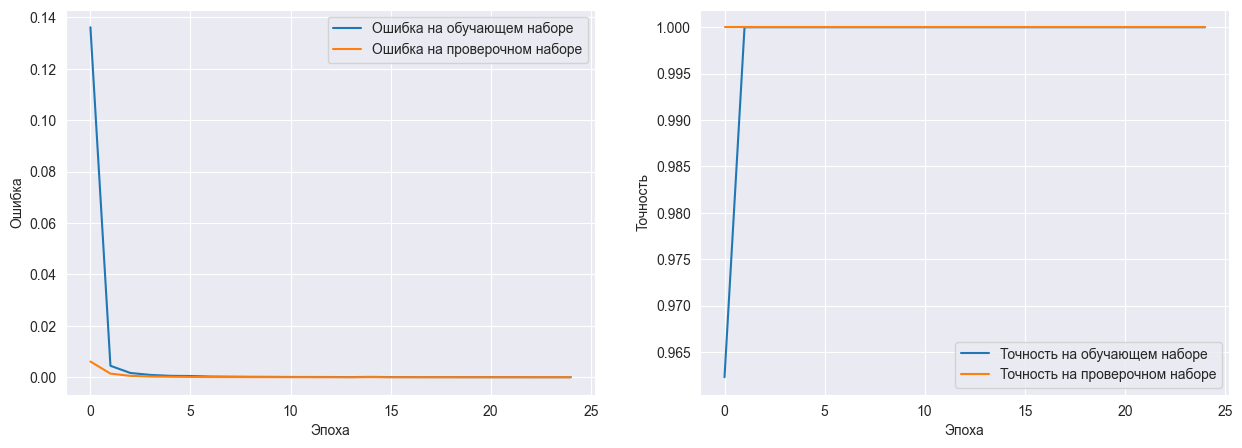

In [114]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.3, спектр 0.2

In [115]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.3)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 1201) (5000, 301)
signal_1_fft (5000, 1201)
signal_2_fft (5000, 301)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_38 (Dense)            (None, 64)                96192     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 2s 8ms/step - loss: 0.0946 - accuracy: 0.9769 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 2/25
219/219 [========================

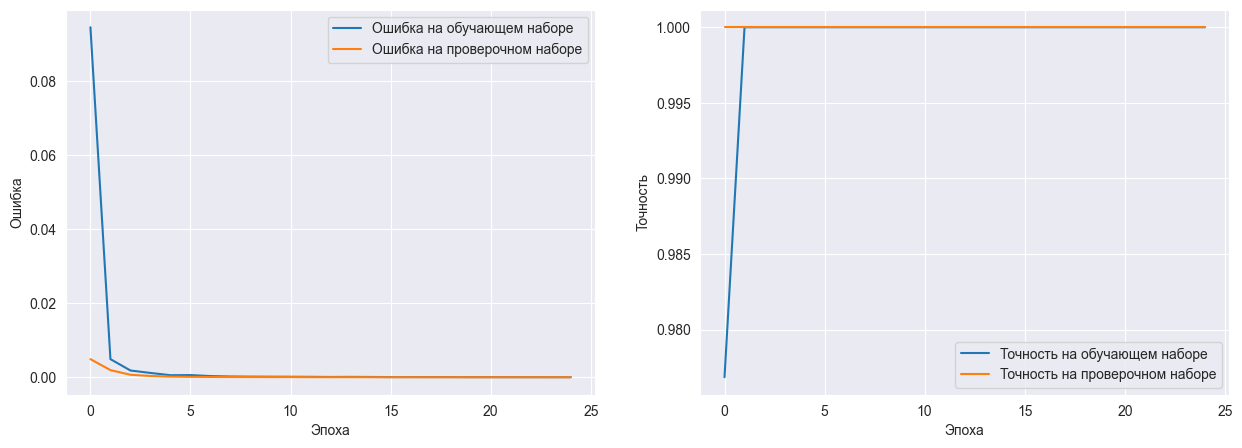

In [116]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.2, спектр 0.2

In [117]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 1201) (5000, 301)
signal_1_fft (5000, 1201)
signal_2_fft (5000, 301)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_40 (Dense)            (None, 64)                96192     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 2s 8ms/step - loss: 0.1209 - accuracy: 0.9634 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 2/25
219/219 [========================

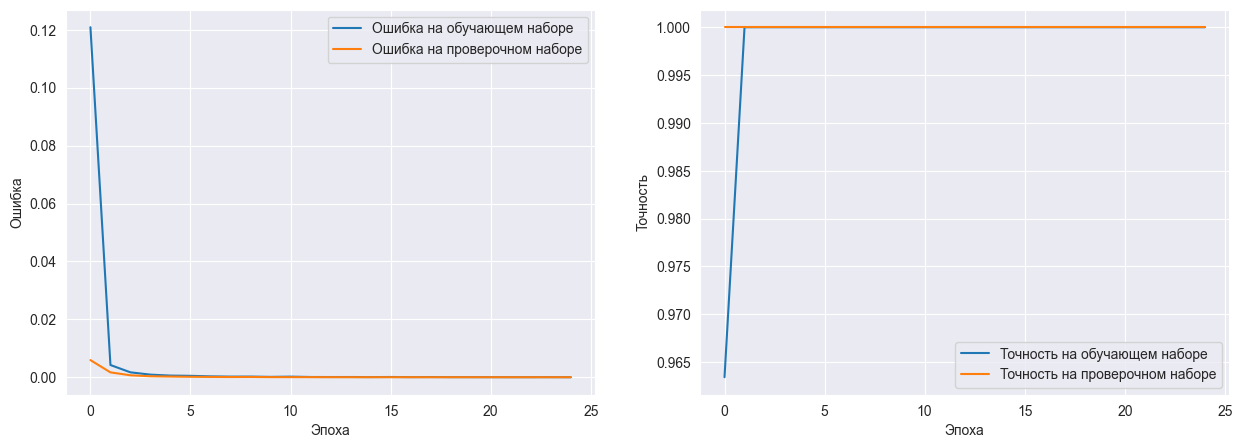

In [118]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Исходное перекрытие 0.1, спектр 0.2

In [9]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.1)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

Размеры спектров (5000, 1201) (5000, 301)
signal_1_fft (5000, 1201)
signal_2_fft (5000, 301)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_42 (Dense)            (None, 64)                96192     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [==============================] - 2s 7ms/step - loss: 0.1670 - accuracy: 0.9557 - val_loss: 0.0203 - val_accuracy: 0.9980
Epoch 2/25
219/219 [========================

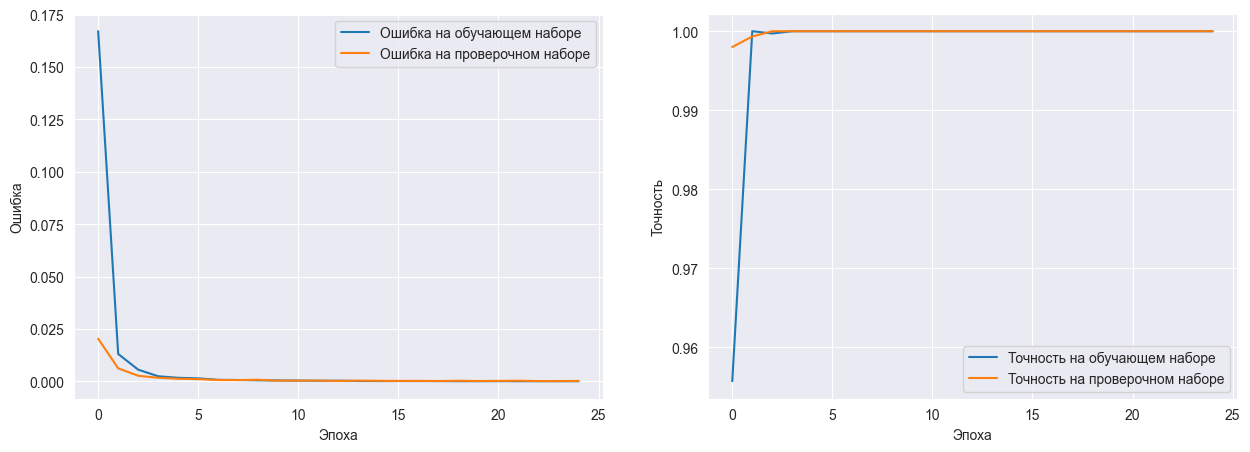

In [120]:
input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


# Берем спектр 0.2, перекрытие 0.2, экспериментируе с длиной окна

Размеры спектров (5000, 1201) (5000, 301)
signal_1_fft (5000, 1201)
signal_2_fft (5000, 301)
X_train (3500, 1502)
y_train (3500, 2)
X_test (1500, 1502)
y_test (1500, 2)
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_44 (Dense)            (None, 64)                96192     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 2)                 130       
                                                                 
Total params: 96,322
Trainable params: 96,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/21

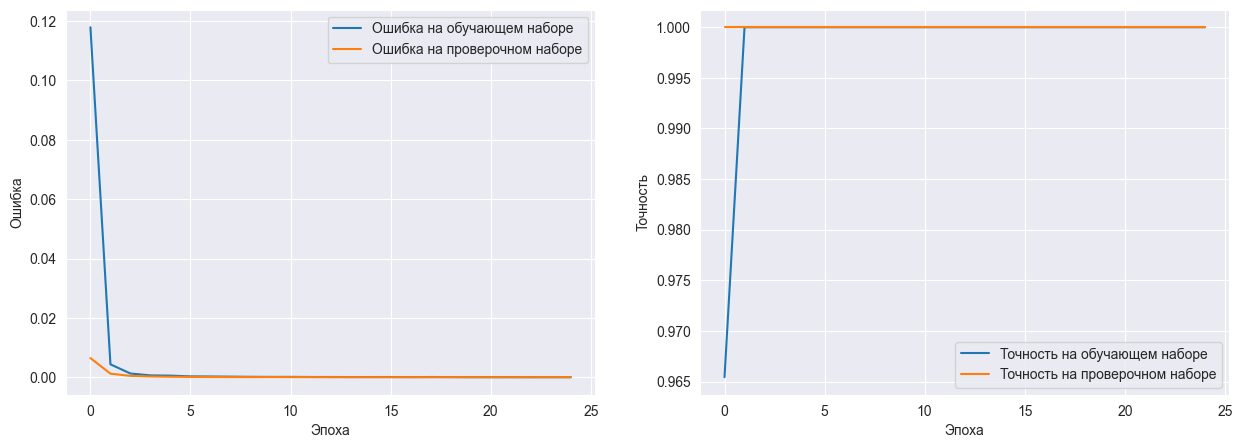

In [122]:
signals, y = make_signals(WINDOW = 3000, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)


Размеры спектров (5000, 801) (5000, 201)
signal_1_fft (5000, 801)
signal_2_fft (5000, 201)
X_train (3500, 1002)
y_train (3500, 2)
X_test (1500, 1002)
y_test (1500, 2)
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 1002)]            0         
                                                                 
 dense_46 (Dense)            (None, 64)                64192     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 2)                 130       
                                                                 
Total params: 64,322
Trainable params: 64,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 

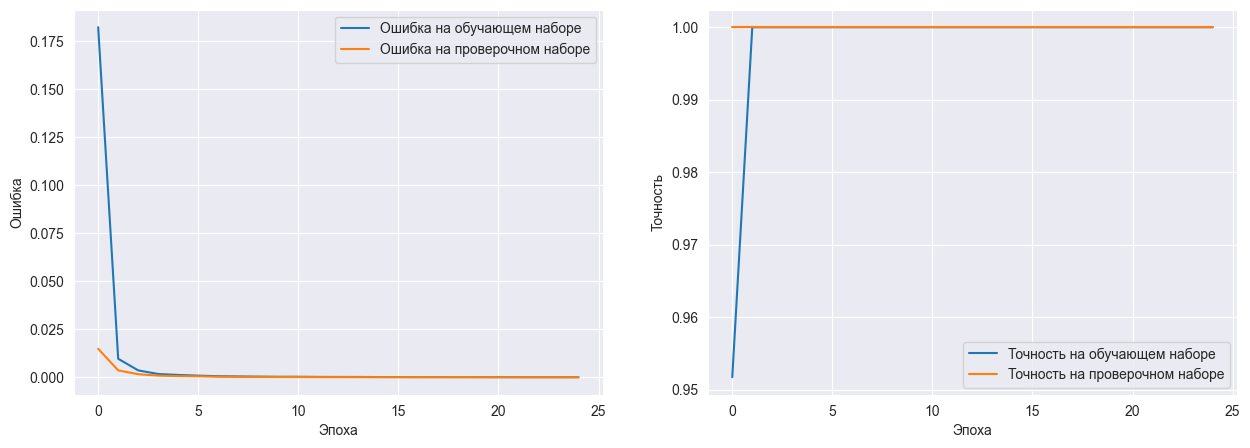

In [123]:
signals, y = make_signals(WINDOW = 2000, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)

Размеры спектров (5000, 401) (5000, 101)
signal_1_fft (5000, 401)
signal_2_fft (5000, 101)
X_train (3500, 502)
y_train (3500, 2)
X_test (1500, 502)
y_test (1500, 2)
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 502)]             0         
                                                                 
 dense_48 (Dense)            (None, 64)                32192     
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 2)                 130       
                                                                 
Total params: 32,322
Trainable params: 32,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [=

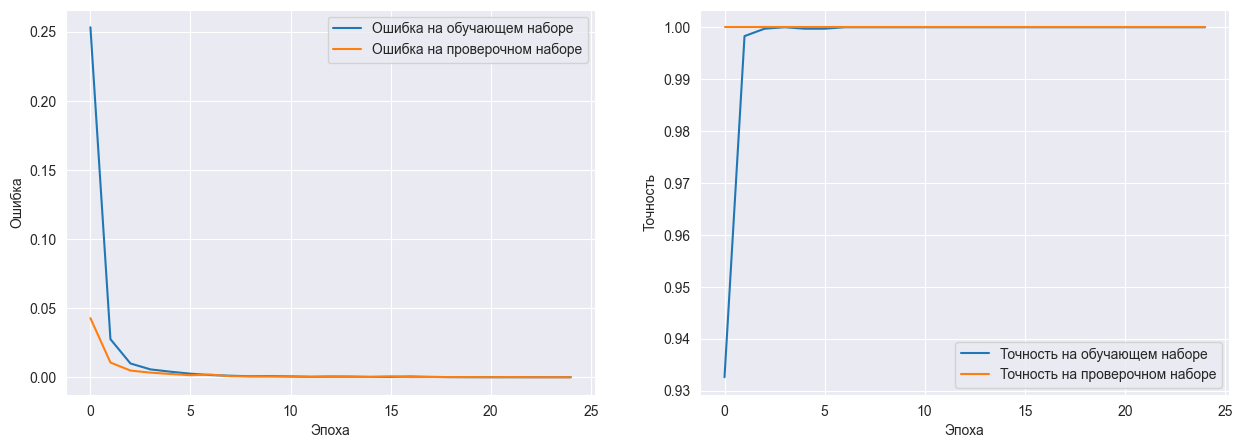

In [124]:
signals, y = make_signals(WINDOW = 1000, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)

Размеры спектров (5000, 201) (5000, 51)
signal_1_fft (5000, 201)
signal_2_fft (5000, 51)
X_train (3500, 252)
y_train (3500, 2)
X_test (1500, 252)
y_test (1500, 2)
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 252)]             0         
                                                                 
 dense_50 (Dense)            (None, 64)                16192     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 2)                 130       
                                                                 
Total params: 16,322
Trainable params: 16,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [===

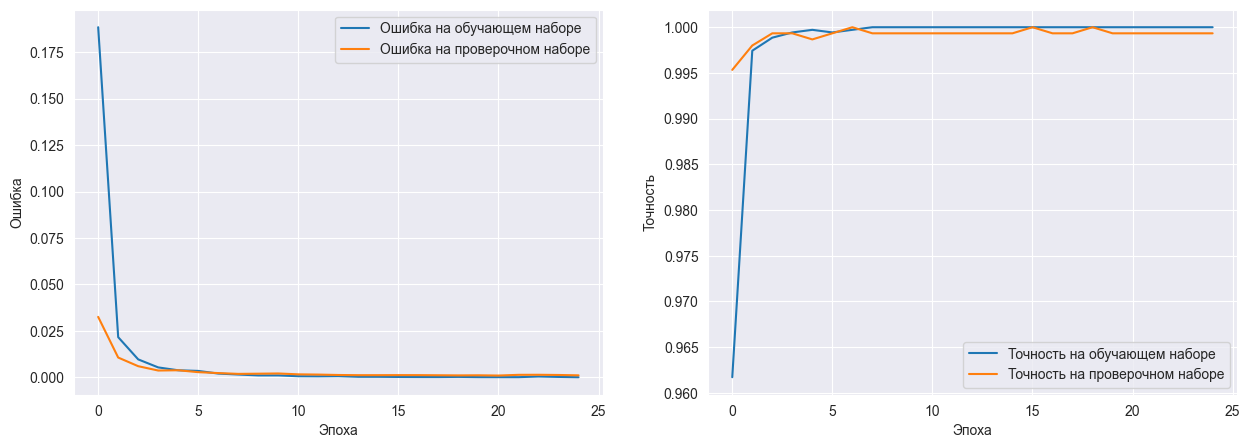

In [125]:
signals, y = make_signals(WINDOW = 500, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)

Размеры спектров (5000, 101) (5000, 26)
signal_1_fft (5000, 101)
signal_2_fft (5000, 26)
X_train (3500, 127)
y_train (3500, 2)
X_test (1500, 127)
y_test (1500, 2)
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 127)]             0         
                                                                 
 dense_58 (Dense)            (None, 64)                8192      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 2)                 130       
                                                                 
Total params: 8,322
Trainable params: 8,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
219/219 [=====

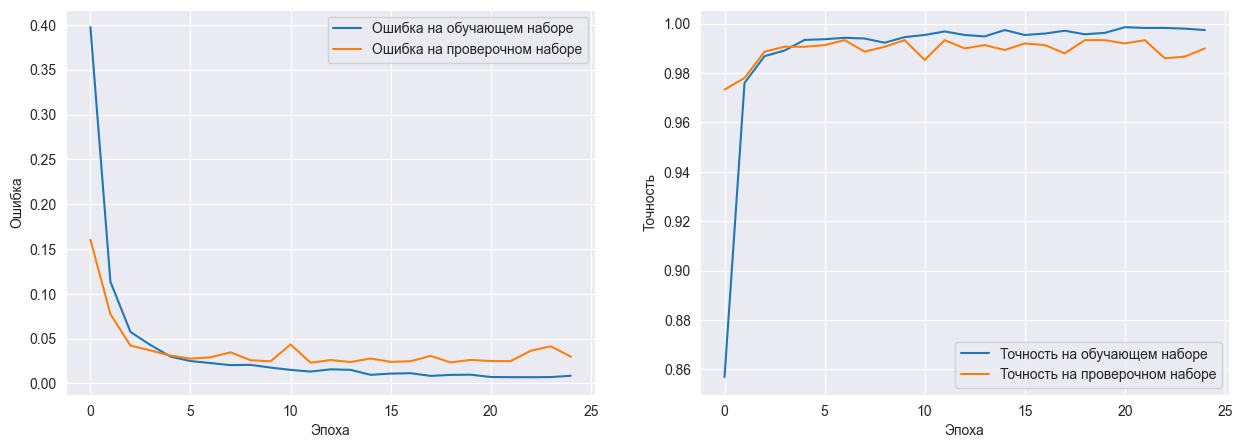

In [135]:
signals, y = make_signals(WINDOW = 250, N_signals = 5000, overlap = 0.2)
signal_1_fft, signal_2_fft = make_spectr(signals,second_part = 0.2)
X_train, X_test, y_train, y_test = prepare_data_1(signal_1_fft, signal_2_fft, y)

input1 = Input(X_train.shape[1])
l = Dense(64, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)


model = compile_and_learn(model, X_train, y_train, X_test, y_test, epochs = 25, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)

In [136]:
model.predict(X_test)

47/47 [==============================] - 0s 2ms/step


array([[9.9999976e-01, 1.9431336e-07],
       [1.5880738e-03, 9.9841189e-01],
       [2.9636570e-03, 9.9703634e-01],
       ...,
       [2.3445587e-05, 9.9997652e-01],
       [9.9999404e-01, 5.9494969e-06],
       [2.5217437e-07, 9.9999976e-01]], dtype=float32)

# Берем весь спектр окна для сравнения с АКФ